In [1]:
import io
from google.colab import files
uploaded = files.upload()

Saving Sexism.csv to Sexism.csv


In [2]:
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['Sexism.csv']))

In [3]:
df1 = df.copy()

In [ ]:
df.shape

(2000, 6)

In [4]:
df.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev
2,sexism2022_english-3553,I agree with that but at the same time I know ...,sexist,2. derogation,2.1 descriptive attacks,dev
3,sexism2022_english-13328,democrats from Minnesota (leftist muzzie shith...,sexist,2. derogation,2.2 aggressive and emotive attacks,dev
4,sexism2022_english-81,Texas jury sentences Jordanian immigrant to de...,not sexist,none,none,dev


In [ ]:
df.columns

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector',
       'split'],
      dtype='object')

In [ ]:
print(df.isna().sum())

rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
split             0
dtype: int64


In [5]:
!pip install pandas transformers scikit-learn nltk torch

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

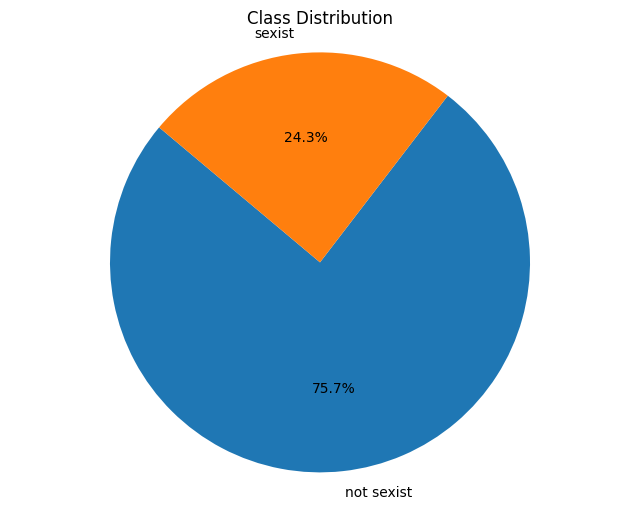

In [8]:
# Calculate class counts
class_counts = df['label_sexist'].value_counts()

plt.figure(figsize = (8, 6))
plt.pie(class_counts, labels = class_counts.index, autopct = '%1.1f%%', startangle = 140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

In [9]:
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# Download the punkt tokenizer
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(cleaned_tokens)

df1['Cleaned_text'] = df1['text'].apply(clean_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df1['label_sexist'] = encoder.fit_transform(df1['label_sexist'])

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df1['Cleaned_text'], df1['label_sexist'], test_size = 0.2, random_state = 42)

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Applying DistilBert

In [11]:
!pip install wandb

# This is a command you run in your terminal or command prompt. It uses the pip package manager to install the WandB Python library. This library provides
# the functions you'll use in your code to log data to WandB.

# wandb login: After installing the library, you run this command in your terminal. This command will prompt you to enter your API key (the long string of
# characters shown, 08bd8456e690481a3d8b60211d080f44ac4bb761 in your case, but don't share this publicly). This key verifies your identity and allows your
# code to send data to your WandB account. Never hardcode your API key directly into your code; use environment variables as explained previously.


In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(X_train.tolist(), truncation = True, padding = True)
test_encodings = tokenizer(X_test.tolist(), truncation = True, padding = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
# Convert to PyTorch datasets
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train.tolist())
test_dataset = MyDataset(test_encodings, y_test.tolist())

In [16]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = len(encoder.classes_))

training_args = TrainingArguments(
    output_dir = './results',            # output directory
    num_train_epochs = 3,                # total number of training epochs
    per_device_train_batch_size = 8,     # batch size per device during training
    per_device_eval_batch_size = 8,      # batch size for evaluation
    warmup_steps = 500,                  # number of warmup steps for learning rate scheduler
    weight_decay = 0.01,                 # strength of weight decay
    logging_dir = './logs',              # directory for storing logs
    evaluation_strategy = "epoch",
    run_name = "my-sexist-detection-run" # Add a unique run name
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
)

trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.586081
2,No log,0.594926
3,0.474000,0.643940


TrainOutput(global_step=600, training_loss=0.4494659042358398, metrics={'train_runtime': 2191.5571, 'train_samples_per_second': 2.19, 'train_steps_per_second': 0.274, 'total_flos': 60852211257600.0, 'train_loss': 0.4494659042358398, 'epoch': 3.0})

In [ ]:
# The absence of logs for Training Loss in the first two epochs is likely due to how your training loop or framework is configured to log metrics. Here 
# are some possible explanations:

# 1. Delayed Logging for Training Loss 
# Some training configurations skip logging the Training Loss during the first few epochs to reduce overhead or only log it at specific intervals (e.g., 
# at the end of an epoch).
# If you're using a deep learning framework like TensorFlow or PyTorch, the code might log only the Validation Loss at the end of each epoch but only 
# capture the Training Loss periodically or for the last epoch.

# 2. Logging Issue
# Your training script might not have been set up to log the Training Loss in earlier epochs. For instance:
# The on_epoch_end callback might only report Validation Loss.
# Training Loss might only be computed at the end of the final epoch.

# 3. Lazy Calculation of Training Loss
# In some cases, Training Loss may not be calculated until later in the training loop for efficiency reasons. If you have a lot of data, the framework 
# may skip logging intermediate metrics until it has processed a significant batch or the entire epoch.

# 4. Implementation Issue
# The function responsible for logging the Training Loss might not be active in the first two epochs due to an error in code logic or configuration.



# Steps to Fix / Verify:
# Check Your Logging Code:
# Ensure that your Training Loss logging logic is correct and active for all epochs.
# If using a library like PyTorch, ensure you're explicitly logging the loss inside the training loop.

# Increase Logging Verbosity:
# In frameworks like TensorFlow or Keras, you can enable more frequent logging by setting verbose=1 or using a ProgbarLogger.

# Debug by Printing Training Loss:
# If you're unsure, add print statements to verify that the Training Loss is being computed but not logged.

# Check the Callback Configuration:
# If you're using callbacks (e.g., ModelCheckpoint or EarlyStopping), ensure they aren't suppressing the Training Loss log.



# Steps to Ensure Training Logs Are Captured
# Ensure the datasets (train_dataset and test_dataset) are tokenized correctly using the DistilBertTokenizer.
# Verify that the len(encoder.classes_) matches the number of unique classes in your dataset.
# Check the logs directory for TensorBoard logs. Run:

# tensorboard --logdir=./logs

# to visualize the training progress.
# If training loss logs are missing, you might need to explicitly enable logging using the logging_steps parameter in TrainingArguments. For example:

# logging_steps = 50, # Logs every 50 steps --> This should ensure training logs are complete and available.


In [18]:
# Evaluation:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis = -1)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, predicted_labels))
print(f"Accuracy: {accuracy_score(y_test, predicted_labels)}")


              precision    recall  f1-score   support

           0       0.85      0.88      0.86       296
           1       0.62      0.56      0.59       104

    accuracy                           0.80       400
   macro avg       0.73      0.72      0.72       400
weighted avg       0.79      0.80      0.79       400

Accuracy: 0.795


In [ ]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, predicted_labels)
# print("Confusion Matrix:")
# print(cm) ???


# The discrepancy between the size of your dataset (2000 rows) and the numbers in the confusion matrix suggests that only a subset of your data was used 
# for evaluation, likely the test set. Here are the possible reasons for this mismatch:

# 1. Train-Test Split
# If you split your dataset into training and testing subsets, the confusion matrix only reflects the evaluation on the test set. For example:
# With an 80-20 split, 20% of 2000 rows (400 rows) are in the test set.
# The confusion matrix reflects predictions for these 400 rows, not the entire dataset.

# Solution:
# Check your data splitting step:
# rom sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)
# print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

# 2. Batch-Based Evaluation
# If you're using a framework like Hugging Face's Trainer, the evaluation is performed batch-wise. Depending on the batch size, the test dataset may not 
# be fully utilized, especially if the number of rows isn't divisible by the batch size.

# Solution:
# Ensure that all test data is used:

# per_device_eval_batch_size = 1  # Set batch size to 1 for testing (optional but ensures no skips)

# 3. Dropped or Filtered Rows
# Some rows may have been excluded from evaluation due to:
# Missing values in features.
# Tokenization errors (e.g., tokenized sequences exceed the model's max_length).
# Intentional filtering (e.g., you filtered out specific rows).

# Solution:
# Verify the size of your test dataset after preprocessing:

# print(f"Test dataset size: {len(test_dataset)}")


Confusion Matrix:
[[260  36]
 [ 46  58]]
